In [1]:
import numpy as np
import torch
import local_utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from local_utils import ResidualBlock
from torch import nn
import cv2
from pathlib import Path
from collections import OrderedDict
from types import SimpleNamespace
import torch.quantization
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

image_size = (640, 480)

# 1. Dane ewaluacyjne

/workspace/SuperPoint/data/rgbd_dataset_freiburg1_floor/rgb
Liczba obrazów w zbiorze testowym: 20


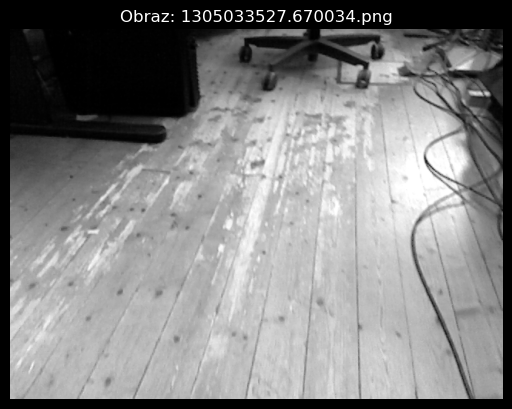

In [2]:
class SuperPointDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        print(Path(image_folder))
        self.image_paths = sorted([str(f) for f in Path(image_folder).iterdir() if f.suffix == ".png"])[:20]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, image_size)
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx].split("/")[-1]

transform = transforms.Compose([transforms.ToTensor()])

test_dataset = SuperPointDataset("/workspace/SuperPoint/data/rgbd_dataset_freiburg1_floor/rgb", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Liczba obrazów w zbiorze testowym: {len(test_dataset)}")
# Wyświetlanie jednego obrazu z test_loader
image, path = test_dataset[0]  # Wybieramy pierwszy obraz
image = image.squeeze(0)  # Usuwamy wymiar kanału (1, H, W)
image = image.numpy()  # Konwertujemy tensor na numpy array

# Wyświetlanie obrazu
plt.imshow(image, cmap='gray')
plt.title(f"Obraz: {path}")
plt.axis('off')  # Ukrycie osi
plt.show()

In [3]:
# class SuperPointDataset(Dataset):
#     def __init__(self, image_folder, transform=None):
#         print(Path(image_folder))
#         self.image_paths = [str(f) for f in Path(image_folder).iterdir() if f.suffix == ".ppm"]
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
#         image = cv2.resize(image, image_size)
#         if self.transform:
#             image = self.transform(image)
#         return image, self.image_paths[idx]

# transform = transforms.Compose([transforms.ToTensor()])

# test_dataset = SuperPointDataset("./data", transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# print(f"Liczba obrazów w zbiorze testowym: {len(test_dataset)}")
# # Wyświetlanie jednego obrazu z test_loader
# image, path = test_dataset[0]  # Wybieramy pierwszy obraz
# image = image.squeeze(0)  # Usuwamy wymiar kanału (1, H, W)
# image = image.numpy()  # Konwertujemy tensor na numpy array


# # Wyświetlanie obrazu
# plt.imshow(image, cmap='gray')
# plt.title(f"Obraz: {path}")
# plt.axis('off')  # Ukrycie osi
# plt.show()

# 2. Inicjalizacja modelu zmiennoprzecinkowego

In [4]:
def sample_descriptors(keypoints, descriptors, s: int = 8):
    """Interpolate descriptors at keypoint locations"""
    b, c, h, w = descriptors.shape
    keypoints = (keypoints + 0.5) / (keypoints.new_tensor([w, h]) * s)
    keypoints = keypoints * 2 - 1  # normalize to (-1, 1)
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode="bilinear", align_corners=False
    )
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1
    )
    return descriptors


def batched_nms(scores, nms_radius: int):
    assert nms_radius >= 0

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius
        )

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


def select_top_k_keypoints(keypoints, scores, k):
    if k >= len(keypoints):
        return keypoints, scores
    scores, indices = torch.topk(scores, k, dim=0, sorted=True)
    return keypoints[indices], scores


class VGGBlock(nn.Sequential):
    def __init__(self, c_in, c_out, kernel_size, relu=True):
        padding = (kernel_size - 1) // 2
        conv = nn.Conv2d(
            c_in, c_out, kernel_size=kernel_size, stride=1, padding=padding
        )
        activation = nn.ReLU(inplace=True) if relu else nn.Identity()
        bn = nn.BatchNorm2d(c_out, eps=0.001)
        super().__init__(
            OrderedDict(
                [
                    ("conv", conv),
                    ("activation", activation),
                    ("bn", bn),
                ]
            )
        )


class SuperPointNet(nn.Module):
    """ Pytorch definition of SuperPoint Network. """
    default_conf = {
        "nms_radius": 4,
        "max_num_keypoints": 500,
        "detection_threshold": 0.005,
        "remove_borders": 4,
        "descriptor_dim": 256,
        "channels": [64, 64, 128, 128, 256],
    }
    def __init__(self, **conf):
        super(SuperPointNet, self).__init__()

        conf = {**self.default_conf, **conf}
        self.conf = conf
        
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
        self.relu = torch.nn.ReLU(inplace=True)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.relu3 = torch.nn.ReLU(inplace=True)
        self.relu4 = torch.nn.ReLU(inplace=True)
        self.relu5 = torch.nn.ReLU(inplace=True)
        self.relu6 = torch.nn.ReLU(inplace=True)
        self.relu7 = torch.nn.ReLU(inplace=True)
        self.relu8 = torch.nn.ReLU(inplace=True)
        self.relu9 = torch.nn.ReLU(inplace=True)
        self.relu10 = torch.nn.ReLU(inplace=True)
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = torch.nn.Conv2d(
            1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = torch.nn.Conv2d(
            c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = torch.nn.Conv2d(
            c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = torch.nn.Conv2d(
            c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = torch.nn.Conv2d(
            c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = torch.nn.Conv2d(
            c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = torch.nn.Conv2d(
            c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = torch.nn.Conv2d(
            c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = torch.nn.Conv2d(
            c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = torch.nn.Conv2d(
            c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = torch.nn.Conv2d(
            c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = torch.nn.Conv2d(
            c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """ Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
        x: Image pytorch tensor shaped N x 1 x H x W.
        Output
        semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
        desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """
        # Shared Encoder.
        x = self.quant(x)
        x = self.relu1(self.conv1a(x))
        x = self.relu2(self.conv1b(x))
        x = self.pool1(x)
        x = self.relu3(self.conv2a(x))
        x = self.relu4(self.conv2b(x))
        x = self.pool2(x)
        x = self.relu5(self.conv3a(x))
        x = self.relu6(self.conv3b(x))
        x = self.pool3(x)
        x = self.relu7(self.conv4a(x))
        x = self.relu8(self.conv4b(x))
        # Detector Head.
        cPa = self.relu9(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu10(self.convDa(x))
        desc = self.convDb(cDa)
        desc = self.dequant(desc)
        # dn = torch.norm(desc, p=2, dim=1)  # Compute the norm.
        # desc = desc.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.
        # desc = torch.nn.functional.normalize(desc, p=2, dim=1, eps=1e-6)
        return self.dequant(semi), desc

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
detection_thresh = 0.005
nms_radius = 5

float_model = SuperPointNet(detection_threshold=detection_thresh, nms_radius=nms_radius).eval()
float_model.load_state_dict(torch.load("superpoint_v1.pth"))
# conf = float_model.conf
input_shape = (1, 1, image_size[1], image_size[0])
model = float_model.to(device)

print(device)

cuda


### Superpoint with brevitas

In [ ]:
import torch
import torch.nn as nn
from torch.nn.init import xavier_uniform_, zeros_

from brevitas.nn import QuantConv2d, QuantIdentity, QuantReLU
from brevitas import config

from brevitas.core.quant import QuantType
from brevitas.quant import (
    Int8ActPerTensorFloat,
    Int8WeightPerTensorFixedPoint,
    Uint8ActPerTensorFloat,
)
from brevitas.core.restrict_val import RestrictValueType
from brevitas.quant import Int16Bias

config.IGNORE_MISSING_KEYS = True


class UIntActQuant(Uint8ActPerTensorFloat):
    """Floating point scales restricted to 2e-5 (to avoid floating-point shenanigans during streamlining)"""
    scaling_min_val = 2e-5
    restrict_scaling_type = RestrictValueType.LOG_FP


class SuperPointNet_pretrained(torch.nn.Module):
    """Pytorch definition of SuperPoint Network."""
    default_conf = {
            "nms_radius": 4,
            "max_num_keypoints": 500,
            "detection_threshold": 0.005,
            "remove_borders": 4,
            "descriptor_dim": 256,
            "channels": [64, 64, 128, 128, 256],
        }
    def __init__(self, **conf):
        
        conf = {**self.default_conf, **conf}
        self.conf = conf
        super(SuperPointNet_pretrained, self).__init__()
        self.relu = torch.nn.ReLU(inplace=True)

        # qnn.QuantReLU(quant_type=QuantType.F),
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        
        bit_width = 4
        # Shared Encoder.
        self.conv1a = QuantConv2d(
            1,
            c1,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu1a = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.conv1b = QuantConv2d(
            c1,
            c1,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu1b = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.conv2a = QuantConv2d(
            c1,
            c2,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu2a = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.conv2b = QuantConv2d(
            c2,
            c2,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu2b = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.conv3a = QuantConv2d(
            c2,
            c3,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu3a = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.conv3b = QuantConv2d(
            c3,
            c3,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu3b = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.conv4a = QuantConv2d(
            c3,
            c4,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu4a = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.conv4b = QuantConv2d(
            c4,
            c4,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.relu4b = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        # Detector Head.
        self.convPa = QuantConv2d(
            c4,
            c5,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.reluPa = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.convPb = QuantConv2d(
            c5,
            65,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        # Descriptor Head.
        self.convDa = QuantConv2d(
            c4,
            c5,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )
        self.reluDa = QuantReLU(
            act_quant=UIntActQuant,
            bit_width=bit_width
        )
        self.convDb = QuantConv2d(
            c5,
            d1,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
            weight_bit_width=bit_width,
            # weight_quant=Int8WeightPerTensorFixedPoint,
            # bias_quant=Int16Bias,
        )

    def forward(self, x):
        """Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
          x: Image pytorch tensor shaped N x 1 x H x W.
        Output
          semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
          desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """

        # x = self.quant_inp(x)
        # Shared Encoder.
        x = self.relu1a(self.conv1a(x))
        x = self.relu1b(self.conv1b(x))
        x = self.pool(x)
        x = self.relu2a(self.conv2a(x))
        x = self.relu2b(self.conv2b(x))
        x = self.pool(x)
        x = self.relu3a(self.conv3a(x))
        x = self.relu3b(self.conv3b(x))
        x = self.pool(x)
        x = self.relu4a(self.conv4a(x))
        x = self.relu4b(self.conv4b(x))
        # Detector Head.
        cPa = self.reluPa(self.convPa(x))
        semi = self.convPb(cPa)

        # Descriptor Head.
        cDa = self.reluDa(self.convDa(x))
        desc = self.convDb(cDa)
        # dn = torch.norm(desc, p=2, dim=1)  # Compute the norm.
        # desc = desc.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.
        output = {"semi": semi, "desc": desc}
        return semi, desc



### LOADING PRETRAINED MODEL QUANTIZED SuperPointNet - 4bits

In [ ]:
ptq_model = SuperPointNet_pretrained()
model_weights = torch.load('/workspace/SuperPoint/kria_evaluation/superPointNet_157000_checkpoint.pth.tar')
ptq_model.load_state_dict(model_weights['model_state_dict'])
ptq_model.to(device)

print(f"Original float weight tensor:\n {ptq_model.conv2a.weight} \n")
print(f"Quantized weight QuantTensor:\n {ptq_model.conv2a.quant_weight()} \n")

# convert to onnx with brevitas
ptq_model.eval()
dummy_input = torch.randn(1, 1, image_size[1], image_size[0]).to(device)


Original float weight tensor:
 Parameter containing:
tensor([[[[-2.6250e-02,  9.6043e-04, -8.3465e-03],
          [-5.7202e-03,  5.6807e-02, -2.3808e-03],
          [-2.6305e-03,  2.8983e-02,  8.1130e-03]],

         [[ 7.1027e-05, -3.6866e-03, -1.2028e-03],
          [-4.5575e-03, -3.6061e-03, -4.0626e-03],
          [ 3.8179e-03,  6.2669e-03,  6.1661e-03]],

         [[ 4.9677e-04,  7.2921e-03, -9.5116e-04],
          [-3.6428e-03, -2.8990e-03, -4.6944e-03],
          [-6.1883e-03, -4.1180e-03, -3.8857e-03]],

         ...,

         [[ 1.0421e-02,  8.2752e-02, -2.3717e-02],
          [ 7.9740e-02,  1.2689e-02,  5.9086e-02],
          [ 1.5033e-02,  7.9329e-04, -5.2185e-02]],

         [[ 7.4631e-02,  1.7919e-02, -3.6165e-02],
          [ 3.0541e-02, -3.3201e-02, -9.8380e-02],
          [ 8.1650e-02,  1.4304e-02, -6.1463e-02]],

         [[-8.4879e-03, -9.4245e-03, -9.9145e-03],
          [-6.6485e-03, -7.5687e-03, -8.7196e-03],
          [ 3.7589e-03,  1.9597e-03, -2.1293e-03]]],




In [ ]:
# !pip install onnx onnxoptimizer

### Export neural network model to qonnx file

In [ ]:
# from brevitas.export import export_onnx_qcdq
from brevitas.export import export_onnx_qcdq, export_qonnx

# set seed
torch.manual_seed(0)

inp = torch.randn(1, 1, 480, 640)
path = 'superpointnet_q.onnx'

print(inp.shape)
# exported_model = export_onnx_qcdq(ptq_model, args=inp, export_path=path, opset_version=13)
exported_model = export_qonnx(ptq_model, args=inp, export_path=path)

/home/vision/danilowi/virtual_envs/fresh/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([1, 1, 480, 640])


# Inspector model

In [ ]:
import pytorch_nndct
print(pytorch_nndct.__version__)
from pytorch_nndct.apis import Inspector
target = "DPUCZDX8G_ISA1_B4096"

inspector = Inspector(target)
rand_in = torch.randn(input_shape).to(device)
inspector.inspect(model, (rand_in,), device=device, output_dir="inspect", image_format="png")

# Postprocessing

In [50]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(torch.__version__)

detection_thresh = 0.005
nms_radius = 5

def match_descriptors(kp1, desc1, kp2, desc2):
    # Match the keypoints with the warped_keypoints with nearest neighbor search
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    matches = bf.match(desc1, desc2)
    matches_idx = np.array([m.queryIdx for m in matches])
    m_kp1 = [kp1[idx] for idx in matches_idx]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_kp2 = [kp2[idx] for idx in matches_idx]

    return m_kp1, m_kp2, matches

def compute_homography(matched_kp1, matched_kp2):
    matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

def preprocess_image(img_file, img_size):
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    # img = cv2.resize(img, img_size)
    img_orig = img.copy()
    img_preprocessed = img.mean(-1) / 255
    #img_preprocessed = np.pad(image, [(0, int(np.ceil(s/8))*8 - s) for s in image.shape[:2]])

    return img_preprocessed, img_orig

def post_processing_short(scores, descriptors_dense, conf):
    b = scores.shape[0]
    scores = batched_nms(scores, conf['nms_radius'])

    # Discard keypoints near the image borders
    if conf['remove_borders']:
        pad = conf['remove_borders']
        scores[:, :pad] = -1
        scores[:, :, :pad] = -1
        scores[:, -pad:] = -1
        scores[:, :, -pad:] = -1

    scores = scores.squeeze(0)
    idxs = torch.where(scores > conf['detection_threshold'])

    # Convert (i, j) to (x, y)
    keypoints_all = torch.stack(idxs[-2:], dim=-1).flip(1).float()
    scores_all = scores[idxs]

    keypoints = []
    scores = []
    descriptors = []
    for i in range(b):
        if b > 1:
            k = keypoints_all[mask[i]]
            s = scores_all[mask[i]]
        else:
            k = keypoints_all
            s = scores_all
        if conf['max_num_keypoints'] is not None:
            k, s = select_top_k_keypoints(k, s, conf['max_num_keypoints'])
        d = sample_descriptors(k[None], descriptors_dense[i, None], 2 ** (len(conf['channels']) - 2))
        keypoints.append(k)
        scores.append(s)
        descriptors.append(d.squeeze(0).transpose(0, 1))

    return {
        "keypoints": keypoints,
        "keypoint_scores": scores,
        "descriptors": descriptors,
    }


def show_comparison(tensors1, tensors2, img1_orig, img2_orig, model):

    # Run inference for both images
    tensors = [tensors1, tensors2]
    keypoints_list = []
    desc_list = []

    for tensor in tensors:
        pred_th_1 = post_processing_short(tensor['scores'], tensor['descriptors_dense'], model.conf)
        descriptors = pred_th_1['descriptors'][0]
        points_th = pred_th_1['keypoints'][0]
        keypoints_np = np.array(points_th.cpu().detach().numpy())  # Konwersja do NumPy
        keypoints = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in keypoints_np]
        keypoints_list.append(keypoints)
        desc_list.append(descriptors.cpu().detach().numpy().astype(np.float32))

    m_kp1, m_kp2, matches = match_descriptors(keypoints_list[0], desc_list[0], keypoints_list[1], desc_list[1])
    H, inliers = compute_homography(m_kp1, m_kp2)

    img1_orig = (img1_orig * 255).astype(np.uint8)
    img2_orig = (img2_orig * 255).astype(np.uint8)

    # Draw SuperPoint matches
    matches = np.array(matches)[inliers.astype(bool)].tolist()
    matched_img = cv2.drawMatches(img1_orig, keypoints_list[0], img2_orig, keypoints_list[1], matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))

    return matched_img

def visualize(model, data_folder, text, image_size=image_size):
    image1, path1 = test_dataset[0]  # Wybieramy pierwszy obraz
    image1 = image1.squeeze(0)  # Usuwamy wymiar kanału (1, H, W)
    image1 = image1.numpy()
    
    image2, path2 = test_dataset[1]  # Wybieramy pierwszy obraz
    image2 = image2.squeeze(0)  # Usuwamy wymiar kanału (1, H, W)
    image2 = image2.numpy()
    
    
    # img1 = cv2.imread(f'data/1.ppm', cv2.IMREAD_COLOR)
    img1 = cv2.resize(image1, image_size)
    print(img1.shape)
    
    # img2 = cv2.imread(f'data/2.ppm', cv2.IMREAD_COLOR)
    img2 = cv2.resize(image2, image_size)
    data0 = torch.load(data_folder + f'outputs_batch_0.pt')
    data1 = torch.load(data_folder + f'outputs_batch_1.pt')
    matched = show_comparison(data0, data1, img1, img2, model)
    matched_rgb = cv2.cvtColor(matched, cv2.COLOR_BGR2RGB)

    # Wyświetlenie obrazu w Jupyter Notebook
    plt.figure(figsize=(10, 5))
    plt.imshow(matched_rgb)
    plt.title(text)
    plt.axis("off")  # Ukrycie osi
    plt.show()

1.13.1+cu117


# Ewaluacja modelu zmiennoprzecinkowego

In [84]:
def evaluate(model, dataloader, device, conf=0.5):
    """
    Porównuje działanie modelu przed i po kwantyzacji.

    :param float_model: model przed kwantyzacją
    :param quantized_model: model po kwantyzacji
    :param dataloader: zbiór testowy
    :param device: urządzenie (CPU/GPU)
    """
    tm = local_utils.TimeMeasurement("Evaluation", len(dataloader))
    
    model.to(device).eval()

    diff_total, count = 0, 0
    tensors = []
    
    layer = QuantIdentity(return_quant_tensor=True, bit_width=4,act_quant=Uint8ActPerTensorFloat)
    layer.to(device).eval()

    with torch.no_grad(), tm:
        for i, (X, *Y) in enumerate(dataloader):
            X = X.to(device)
            print(X.shape)
            # X = layer(X)
            # Forward pass dla modeli
            scores, descriptors_dense = model(X)
            scores = torch.nn.functional.softmax(scores, 1)[:, :-1]

            b, _, h, w = scores.shape
            scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
            scores = scores.permute(0, 1, 3, 2, 4).reshape(
                b, h * 8, w * 8
            )
            keypoints = post_processing_short(scores, descriptors_dense, conf)['keypoints']
            # data = torch.load(f'data/outputs_batch_{i}.pt')

            # data_keypoints = post_processing_short(data['scores'], data['descriptors_dense'], conf)['keypoints']

            torch.save({'scores': scores, 'descriptors_dense': descriptors_dense}, f'data_pt/outputs_batch_{i}.pt')

            # Obliczenie różnicy
            percent_diff = keypoints[0].shape[0]/keypoints[0].shape[0]
            # Aktualizacja wyników
            batch_size = X.shape[0]
            diff_total += percent_diff
            count += batch_size

            print(f"\rEvaluation {i+1}/{len(dataloader)} | keypoints_loss: {percent_diff:.6f}", end='')

    # Średnie wyniki
    diff_avg = diff_total / count

    print(f"\nFinal Evaluation: keypoints_loss = {diff_avg:.6f}")
    print(tm)

    return diff_avg

Na potrzeby ewaluacji wykorzystuje się wcześniej wyliczone wyniki na modelu zmiennprzecinkowym

torch.Size([1, 1, 480, 640])
Evaluation 1/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 2/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 3/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 4/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 5/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 6/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 7/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 8/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 9/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 10/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 11/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 12/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 13/20 | keypoints_loss: 1.000000torch.Size([1, 1, 480, 640])
Evaluation 14/20 | keypoints_loss: 1.000000t

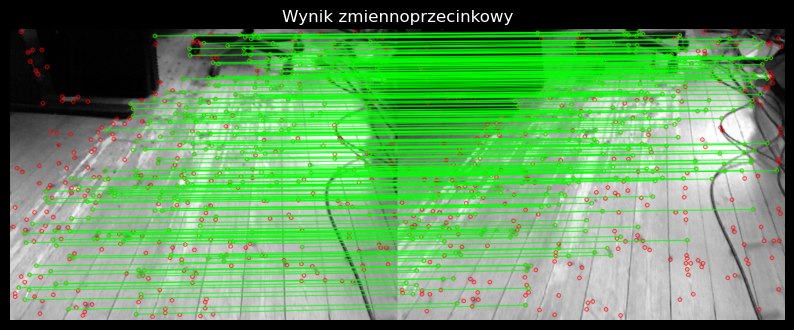

In [85]:
ptq_model.to(device)

evaluate(ptq_model, test_loader, device, ptq_model.conf)
visualize(ptq_model,"data_pt/", "Wynik zmiennoprzecinkowy")

Evaluation 20/20 | keypoints_loss: 1.000000
Final Evaluation: keypoints_loss = 1.000000
Execution time: 0.0:0.0:0:519, processed 20 frames, throughput: 38.47129423041204 fps.
(480, 640)


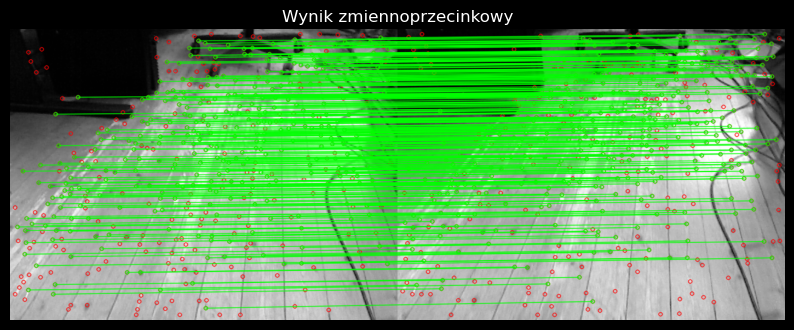

In [47]:
# You can evaluate your floating point model first 
evaluate(model, test_loader, device, model.conf)
visualize(float_model,"data_pt/", "Wynik zmiennoprzecinkowy")

# 4. Kwantyzacja modelu zmiennoprzecinkowego

In [65]:
def compute_sequence(image_folder, model,float_model, tryb='show'):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".ppm"))])
    first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, _ = first_image.shape
    past_descriptors = None
    past_keypoints = None
    for i in range(0, len(image_files), 3):
        image_file = image_files[i]
        image_path = os.path.join(image_folder, image_file)
        image, img_orig = preprocess_image(image_path, image_size)
        scores, descriptors_dense = model(torch.from_numpy(image[None, None]).float())
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
        b, _, h, w = scores.shape
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(
            b, h * 8, w * 8
        )
        pred_th_1 = post_processing_short(scores, descriptors_dense, float_model.conf)
        descriptors = pred_th_1['descriptors'][0].cpu().detach().numpy().astype(np.float32)
        points_th = pred_th_1['keypoints'][0]
        keypoints_np = np.array(points_th.cpu().detach().numpy())  # Konwersja do NumPy
        keypoints = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in keypoints_np]
        if past_descriptors is not None:
            m_kp1, m_kp2, matches = match_descriptors(past_keypoints, past_descriptors, keypoints, descriptors)
            H, inliers = compute_homography(m_kp1, m_kp2)
            matches = np.array(matches)[inliers.astype(bool)].tolist()

            for match in matches:
                pt1 = tuple(map(int, past_keypoints[match.queryIdx].pt))
                pt2 = tuple(map(int, keypoints[match.trainIdx].pt))
                cv2.arrowedLine(img_orig, pt2, pt1, (0, 255, 0), 1, tipLength=0.2)

        past_descriptors = descriptors
        past_keypoints = keypoints
        if tryb=='show':
            cv2.imshow("Film", img_orig)
            
            # Czekaj 30 ms na kolejny obraz (około 30 FPS)
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break  # Wyjście z pętli po naciśnięciu 'q'
        else:
            cv2.imwrite("/workspace/SuperPoint/kria_evaluation/data_pt/matched/" + image_file, img_orig)
    if tryb=='show':
        cv2.destroyAllWindows()
        
def get_film(image_folder):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

    # Ustalamy rozmiar wideo na podstawie pierwszego obrazu
    first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, _ = first_image.shape

    # Nazwa pliku wynikowego wideo
    output_video = 'original.mp4'

    # Tworzymy obiekt VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Wybór kodeka
    fps = 10  # Liczba klatek na sekundę
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Dodajemy obrazy do wideo
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        video_writer.write(image)

    # Zwolnienie zasobów
    video_writer.release()

    print(f"Film zapisany jako {output_video}")

In [70]:
def quantize(float_model:torch.nn.Module, 
             input_shape:tuple,
             quant_dir:str, 
             quant_mode:str, 
             device:torch.device,
             dataloader):
    """
    :param float_model: float model with loaded weights
    :param input_shape: shape of input(CH,W,H)
    :param quant_dir: path to directory with quantized model components
    :param quant_mode: quant_mode in ['calib', 'test'] 
    :param data_loader: data_loader - for 'calib' must be batch_size == 1
    :param evaluator: fcn/obj like: fcn(y_pred, y_ref) -> float 
    """
    tm = local_utils.TimeMeasurement("Quantization", len(dataloader))
    from pytorch_nndct.apis import torch_quantizer, dump_xmodel
    print(f"Input shape: {input_shape}")
    with tm:
        # model to device
        model = float_model.to(device)

        # Force to merge BN with CONV for better quantization accuracy
        optimize = 1

        rand_in = torch.randn(input_shape)
        print("get qunatizer start")
        try:
            quantizer = torch_quantizer(
                quant_mode, model, rand_in, output_dir=quant_dir, device=device, bitwidth=4)
        except Exception as e:
            print("exception:")
            print(e)
            return
        print("get qunatizer end")

        print("get quantized model start")
        quantized_model = quantizer.quant_model
        print("get quantized model end")

        # evaluate
        print("testing start")
        diff = evaluate(quantized_model, dataloader, device, float_model.conf)
        print(f"Testing finished: diff = {diff:.6f}")
        print("testing end")

        # export config
        if quant_mode == 'calib':
            print("export config")
            quantizer.export_quant_config()
            print("export config end")
        # export model
        if quant_mode == 'test':
            print("export xmodel")
            visualize(float_model, "", "Wynik po kwantyzacji")
            quantizer.export_xmodel(deploy_check=False, output_dir=quant_dir)
            quantizer.export_onnx_model(output_dir=quant_dir)
            compute_sequence("/workspace/SuperPoint/data/rgbd_dataset_freiburg1_floor/rgb", quantized_model, model, tryb='save')            
            print("export xmodel end")
    print(tm)
    return quantized_model

In [13]:
# !export NNDCT_QUANTIZE_OPTION=power_of_two

In [71]:
quantized_model = quantize(float_model=model, 
         input_shape=input_shape,
         quant_dir='quant_dir', # directory for quantizer results
         quant_mode='calib',
         device=device,
         dataloader=test_loader)

Input shape: (1, 1, 480, 640)
get qunatizer start

[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- vision
              release --- 6.11.0-25-generic
              version --- #25~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 15 17:20:50 UTC 2
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 7.5.0
               python --- 3.8.6
              pytorch --- 1.13.1+cu117
        vai_q_pytorch --- 3.5.0+60df3f1+torch1.13.1+cu117

[VAIQ_NOTE]: GPU information:
          device name --- NVIDIA GeForce RTX 4070
     device available --- True
         device count --- 1
       current device --- 0

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing SuperPointNet...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ

██████████████████████████████████████████████████| 27/27 [00:00<00:00, 902.13it/s, OpInfo: name = return_0, type = Return]                                  


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quant_dir/SuperPointNet.py)
get qunatizer end
get quantized model start

[VAIQ_NOTE]: =>Get module with quantization.
get quantized model end
testing start


Evaluation 20/20 | keypoints_loss: 1.000000
Final Evaluation: keypoints_loss = 1.000000
Execution time: 0.0:0.0:1:990, processed 20 frames, throughput: 10.045751079827994 fps.
Testing finished: diff = 1.000000
testing end
export config

[VAIQ_NOTE]: =>Exporting quant config.(quant_dir/quant_info.json)
export config end
Execution time: 0.0:0.0:2:295, processed 20 frames, throughput: 8.71269860641201 fps.


Input shape: (1, 1, 480, 640)
get qunatizer start

[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- vision
              release --- 6.11.0-25-generic
              version --- #25~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 15 17:20:50 UTC 2
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 7.5.0
               python --- 3.8.6
              pytorch --- 1.13.1+cu117
        vai_q_pytorch --- 3.5.0+60df3f1+torch1.13.1+cu117

[VAIQ_NOTE]: GPU information:
          device name --- NVIDIA GeForce RTX 4070
     device available --- True
         device count --- 1
       current device --- 0

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization test process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing SuperPointNet...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]:

██████████████████████████████████████████████████| 27/27 [00:00<00:00, 986.72it/s, OpInfo: name = return_0, type = Return]                                  


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quant_dir/SuperPointNet.py)
get qunatizer end
get quantized model start

[VAIQ_NOTE]: =>Get module with quantization.
get quantized model end
testing start


Evaluation 20/20 | keypoints_loss: 1.000000
Final Evaluation: keypoints_loss = 1.000000
Execution time: 0.0:0.0:1:93, processed 20 frames, throughput: 18.294411819933053 fps.
Testing finished: diff = 1.000000
testing end
export xmodel
(480, 640)


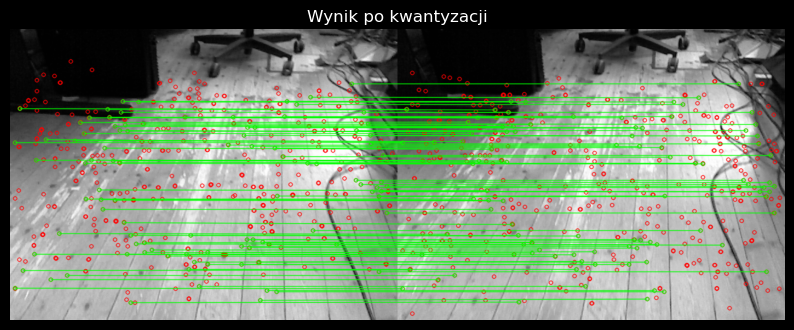


[VAIQ_NOTE]: =>Converting to xmodel ...

[VAIQ_NOTE]: =>Successfully convert 'SuperPointNet' to xmodel.(quant_dir/SuperPointNet_int.xmodel)

[VAIQ_NOTE]: SuperPointNet_int.onnx is generated.(quant_dir/SuperPointNet_int.onnx)
export xmodel end
Execution time: 0.0:0.0:30:440, processed 20 frames, throughput: 0.657026959524684 fps.


RecoveryModel(
  (inner_model): SuperPointNet(
    (module_0): deephi_Input()
    (module_1): deephi_Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (module_2): deephi_ReLU(inplace=True)
    (module_3): deephi_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (module_4): deephi_ReLU(inplace=True)
    (module_5): deephi_MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=[1, 1], ceil_mode=False)
    (module_6): deephi_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (module_7): deephi_ReLU(inplace=True)
    (module_8): deephi_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (module_9): deephi_ReLU(inplace=True)
    (module_10): deephi_MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=[1, 1], ceil_mode=False)
    (module_11): deephi_Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (module_12): deephi_ReLU(inplace=True)
    (module_13): deephi_Conv

In [72]:
quantize(float_model=model, 
         input_shape=input_shape,
         quant_dir='quant_dir', # directory for quantizer results
         quant_mode='test',
         device=device,
         dataloader=test_loader)

Po testowaniu, należy skompilować model. Podajemy odpowiednio parametry:

- --xmodel - ścieżka do zapisanego modelu (zapisany jest w folderze podanym podczas kwantyzacji jako parametr 'quant_dir'
- --arch - podajemy plik arch.json, który znajdował się w pliku. Jest to numer (fingerprint), który określa typ DPU sprzętu docelowego
- --net_name - nazwa naszego modelu po kompilacji - dowolna
- --output_dir - folder do którego zapisany zostanie model

Wagi: inner_model.module_1.weight
Min: -8.0, Max: 7.0
dtype: torch.float32
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2., -2.,  0.,  0.,  0.,
         0.,  1.,  3.,  0.,  6., -5.,  3.,  0., -4.,  0., -1.,  1.,  0.,  1.,
         0.,  1.,  1.,  1., -5.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,
        -4., -1., -3.,  2., -2.,  0.,  2.,  0.,  0.,  0., -1.,  3.,  3.,  0.,
         0.,  0.,  2.,  0.,  2.,  2.,  0., -4.,  0., -2.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  2., -3.,  0.,  2., -2.,  0.,  1.,  0.,  4.,  0., -1.,
         0.,  0.,  0., -2.,  0.,  0.,  0.,  0., -4.,  0.,  3.,  0.,  0.,  0.,
         0.,  3.,  0.,  0.,  1.,  0., -1., -1., -2., -3.,  0., -2.,  0.,  0.,
         0.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

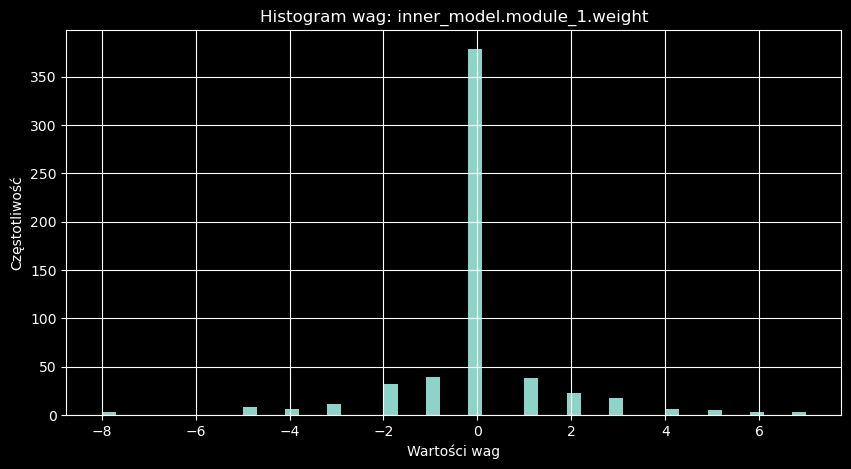

Wagi: inner_model.module_1.bias
Min: -3.089233875274658, Max: 7.019983768463135
dtype: torch.float32
tensor([-7.9468e-02, -3.8192e-02,  1.7507e-02, -1.0889e+00,  4.0411e-02,
        -3.3798e-02,  6.1493e-02, -3.0892e+00, -7.1417e-02, -3.2122e-02,
        -3.5211e-02,  6.7468e-02, -7.2669e-02,  3.0163e-02,  1.2323e-02,
         1.0952e-02, -1.9300e-02, -3.7645e-02, -2.6517e-02, -2.6917e-02,
         3.0308e+00, -6.3777e-03,  2.3346e-02, -4.4636e-02, -9.3820e-03,
        -1.6305e-02, -2.2233e-02, -9.3594e-01, -2.9042e-02,  1.0423e+00,
         8.5046e-01,  1.2303e-01,  7.0200e+00, -9.7788e-01, -9.0209e-01,
        -2.0216e-02, -4.4661e-02,  1.9283e-02, -1.1315e-02, -1.2751e-02,
        -7.8855e-03, -9.5947e-01, -8.4363e-02,  8.2798e-03, -5.8034e-02,
         1.1062e-02,  5.7526e-03, -6.2037e-02,  4.0469e-02,  3.7662e-03,
        -1.1596e-01, -6.2432e-03,  4.8080e-03, -2.1308e-02,  9.2642e-01,
        -9.3833e-03,  7.0142e-02, -5.4062e-02,  6.3525e-03, -3.6467e-03,
         5.4953e-03, -2

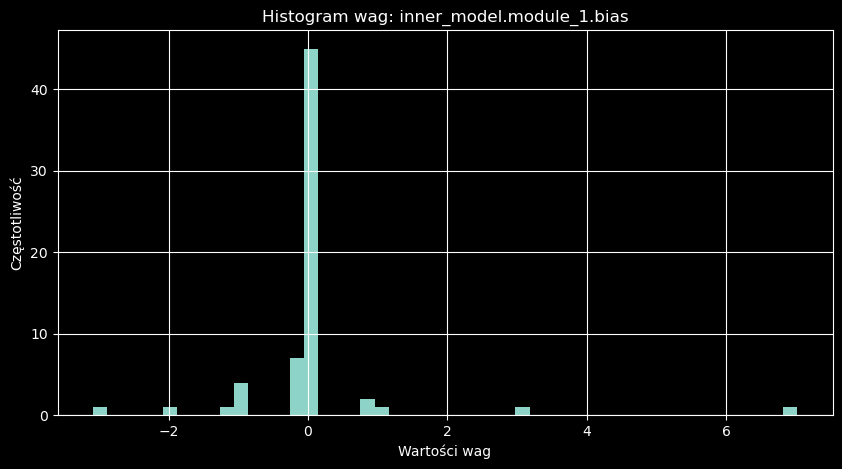

Wagi: inner_model.module_3.weight
Min: -2.0, Max: 1.75
dtype: torch.float32
tensor([0., 0., 0.,  ..., 0., 0., 0.])


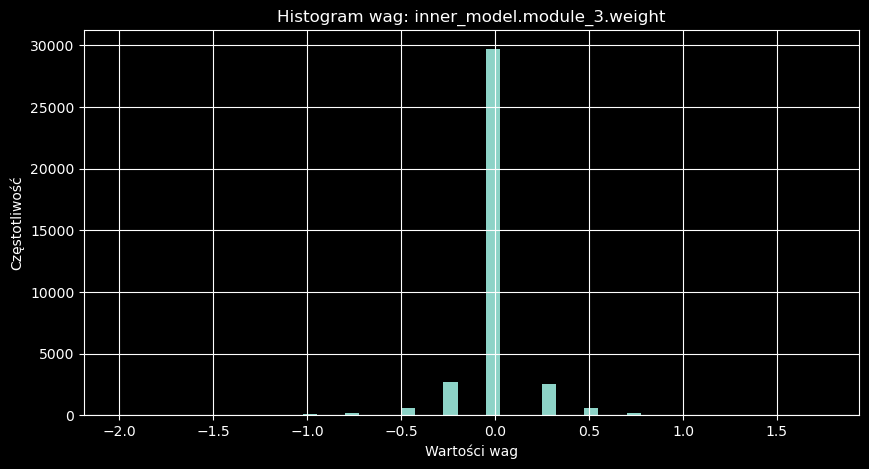

Wagi: inner_model.module_3.bias
Min: -9.41622543334961, Max: 5.522252082824707
dtype: torch.float32
tensor([ 0.2477, -0.0936, -0.5469, -9.4162, -4.1697,  0.2508, -0.4515, -0.1445,
         0.8210, -0.9414,  0.1921, -3.7598,  1.9709,  1.9434, -0.1326,  0.0838,
        -5.5395,  1.1266, -0.7637, -2.9318, -1.1659,  1.1979, -3.9608, -3.2564,
         0.8674,  1.7569, -0.8080,  5.5223, -0.6851, -2.5837, -6.0606, -1.3952,
        -2.2778, -2.4687, -0.0544, -0.2573,  0.8617, -0.2009,  0.9595,  0.5489,
        -0.2558, -7.4589,  1.1954,  0.0665, -0.2064, -1.6562,  2.3304,  0.1506,
        -0.9242, -0.8820,  0.5755,  1.0765, -0.8932, -7.0954,  0.1505, -0.6734,
        -0.0771, -2.5252, -1.4045,  0.1104,  1.5224, -2.1067, -5.9751, -0.8435])


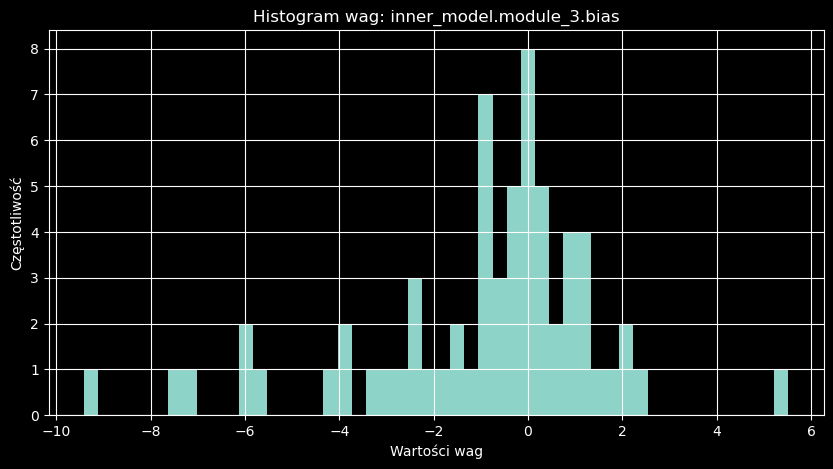

Wagi: inner_model.module_6.weight
Min: -0.5, Max: 0.4375
dtype: torch.float32
tensor([ 0.0625,  0.0000, -0.0625,  ...,  0.0000,  0.0000,  0.0000])


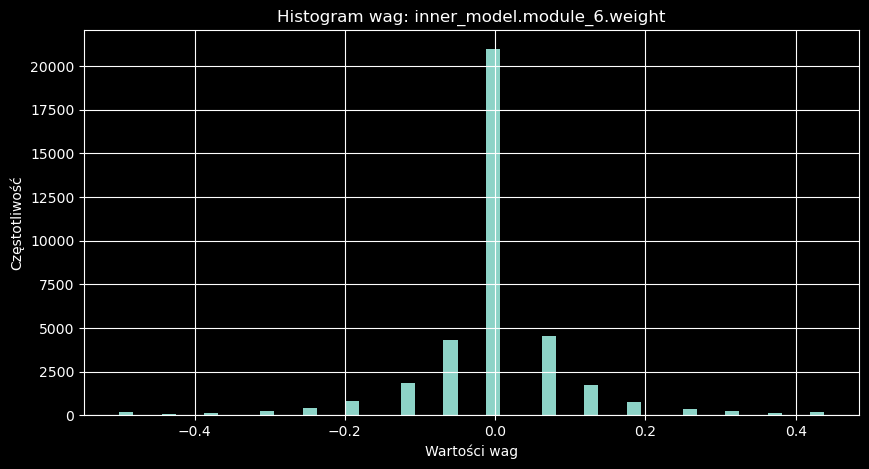

Wagi: inner_model.module_6.bias
Min: -3.635560989379883, Max: 16.182043075561523
dtype: torch.float32
tensor([ 0.9225,  1.6396,  4.3374, -0.6830,  2.2442,  0.1876,  2.3059, -0.1543,
        -0.0721,  0.2826, -0.1027,  4.2593,  3.9701, -0.1314,  1.0587,  6.0491,
        -0.1452,  2.3565, -2.3279, -0.4002, -3.0939,  0.3258, -3.6356,  2.4734,
        -3.4918, -1.7736,  0.5733, -0.3659, -1.4182, -1.5484,  0.4709, -1.4556,
         0.7428,  3.0595, -0.3122,  1.8570, -0.2323, -0.2336, -0.1996, -1.3501,
        -3.6018,  4.1010, -0.3477,  4.9661,  0.1912, -1.6577, -0.4617,  3.4281,
         1.0527,  1.0280, -1.9038, -3.2070, -0.4017,  4.1134,  0.0936,  0.1277,
         3.8831,  3.5019, -2.5727, 16.1820, -0.2981,  2.5037, -0.2248, -0.2658])


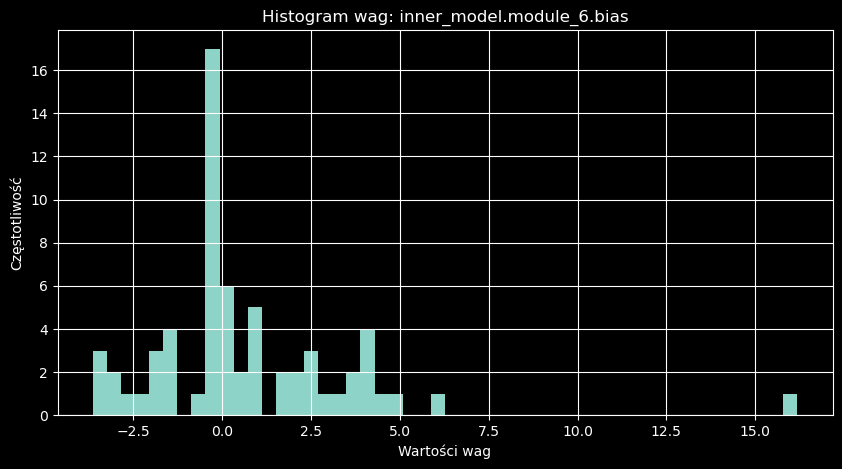

Wagi: inner_model.module_8.weight
Min: -0.5, Max: 0.4375
dtype: torch.float32
tensor([ 0.0000, -0.0625,  0.0625,  ...,  0.0000,  0.0000,  0.0000])


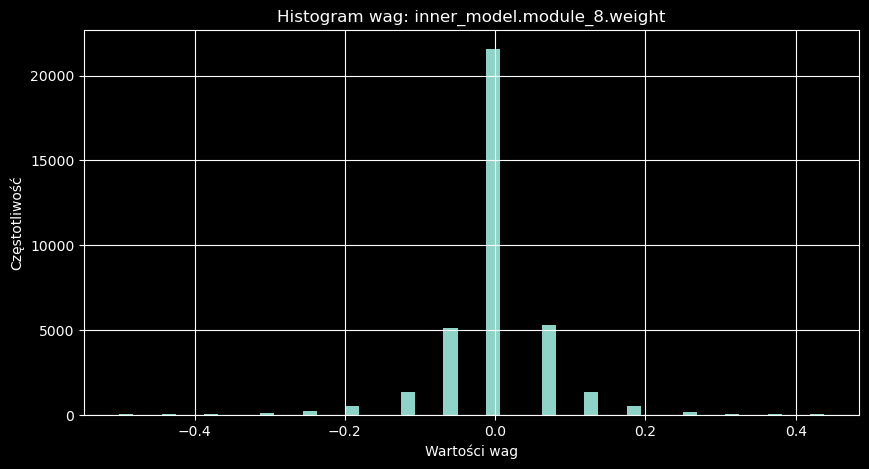

Wagi: inner_model.module_8.bias
Min: -14.433049201965332, Max: 16.15397071838379
dtype: torch.float32
tensor([ -2.1250,   2.8342,  -1.5187,  -1.3566,   7.2564,   6.6678,   0.0395,
         -0.3571,  -7.3705,   1.5672,   3.3745,   5.1426,  -2.9562,   0.7803,
         -4.5040,  -4.2958,   0.8445, -12.3228,   2.5138, -12.0591,   9.9918,
         -6.6600,   3.3144,   5.5106,  -3.2728,  -7.7283,  -0.8119,   9.7746,
         -6.0218,   0.4742,  -4.5029,  -2.5930,   5.8044,  -6.4508,   2.6912,
          3.8678,   1.6584,  -5.4471,   7.9536,   1.4972,   0.3160,  10.5675,
         -0.0418,  -6.5706,  -4.6543,   6.1021,  -2.2852, -14.4330,  -8.5981,
          1.2035,  16.1540,   1.3457,  -2.5104,  -0.1352,  -2.8206,   0.9500,
          9.4532,   2.5666,   2.8673,  -1.2176,  -0.7758,  -1.4564,   0.3289,
         -2.8378])


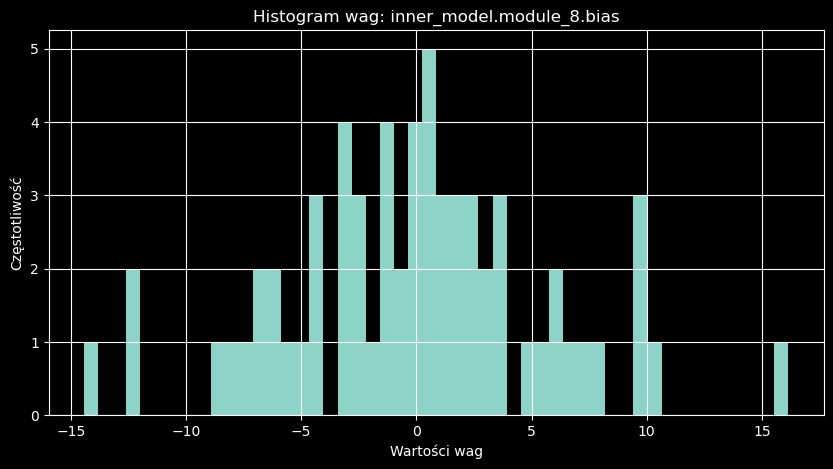

Wagi: inner_model.module_11.weight
Min: -0.5, Max: 0.4375
dtype: torch.float32
tensor([0.0000, 0.0000, 0.0000,  ..., 0.1250, 0.3125, 0.1875])


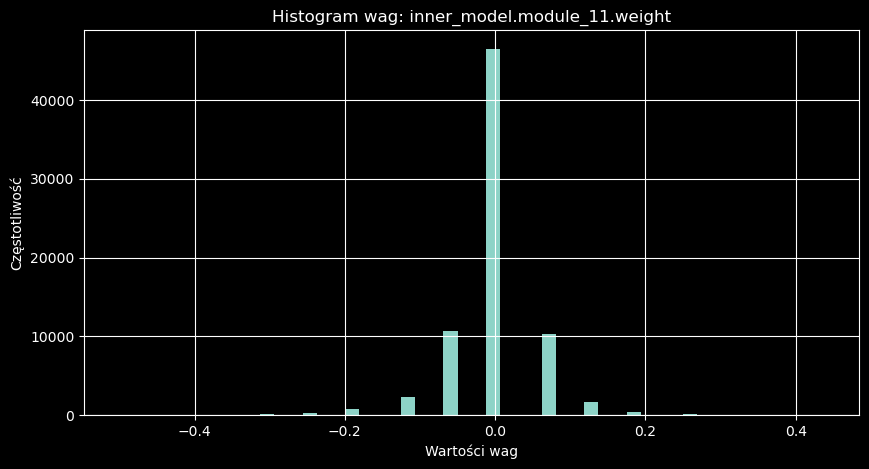

Wagi: inner_model.module_11.bias
Min: -9.193474769592285, Max: 21.814809799194336
dtype: torch.float32
tensor([ 1.2402e+00,  4.3133e+00,  4.4031e+00,  1.1303e+00,  7.0637e-01,
         3.5846e+00,  8.9688e+00, -1.2912e+00,  8.3092e-01, -5.7768e-01,
         4.1104e+00, -4.1694e+00, -9.5098e-01,  5.2662e+00, -1.2546e+00,
         4.2988e-01,  3.9490e+00, -9.1935e+00, -1.5185e-01, -1.1521e-01,
         3.9369e+00,  5.1681e+00,  4.4075e+00,  2.6361e+00,  4.4139e+00,
         3.2011e+00,  6.6040e+00, -9.1646e-03, -7.7127e-01,  2.8676e+00,
         6.0593e+00,  3.1108e+00, -4.5661e+00, -3.3041e-01,  1.8502e+00,
         7.5473e+00,  6.0079e+00, -8.8123e-02,  5.2595e-01,  3.6850e+00,
        -1.4859e+00, -1.5195e-01,  4.1410e+00,  4.1221e+00,  3.8117e+00,
         5.7337e+00, -2.2493e+00, -2.8048e-02,  6.4370e+00,  7.5545e+00,
        -3.7319e+00,  1.2494e+00,  5.0918e+00, -1.0860e-01,  5.7757e+00,
         1.9869e+00,  3.7979e+00,  4.8410e-01,  2.0172e-01,  7.2269e-01,
        -8.9409e-02, 

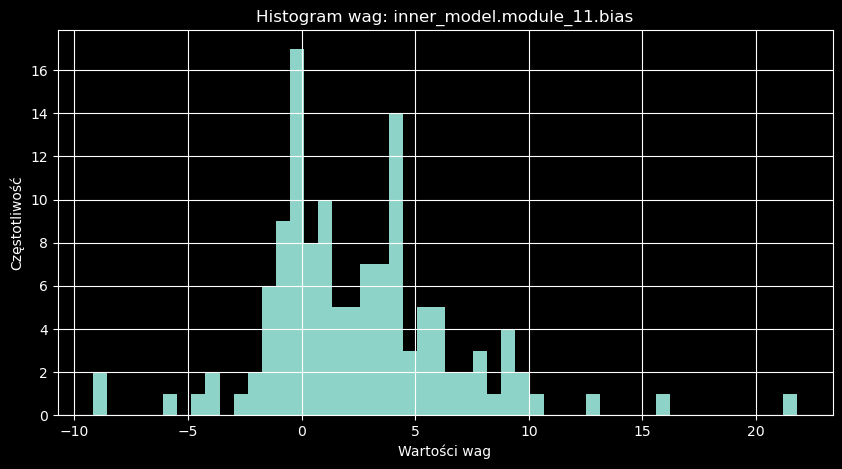

Wagi: inner_model.module_13.weight
Min: -0.25, Max: 0.21875
dtype: torch.float32
tensor([ 0.0000,  0.0312,  0.0000,  ...,  0.0312, -0.0938, -0.0938])


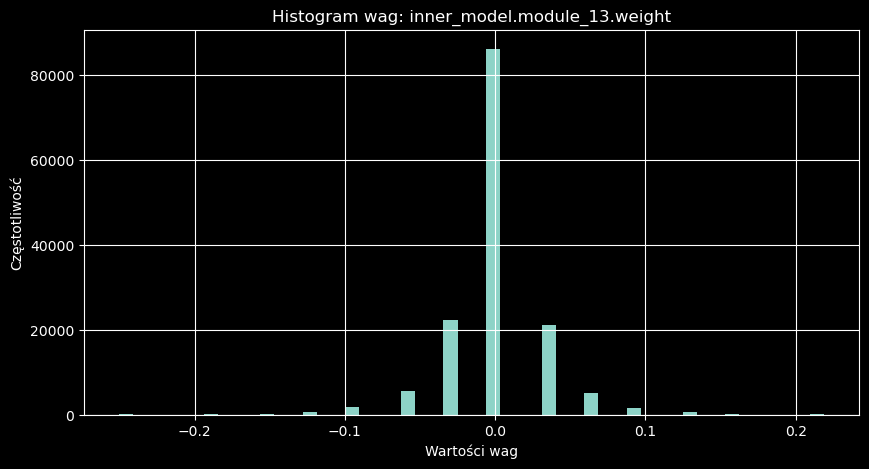

Wagi: inner_model.module_13.bias
Min: -7.962573528289795, Max: 7.807734966278076
dtype: torch.float32
tensor([-9.4961e-01,  9.5724e-01, -1.8363e-01,  2.1716e+00,  3.4470e-02,
         1.6084e+00,  1.9265e+00,  1.1357e+00,  1.0782e-01,  4.0789e+00,
         9.8940e-01,  4.2438e+00,  6.0714e-01,  4.3007e+00,  2.0337e+00,
        -2.8466e-01, -2.1966e+00,  1.8655e+00,  4.2917e-02, -1.0306e+00,
         3.2830e-02, -1.1270e+00, -1.2866e-01, -2.1782e+00,  3.2036e+00,
        -2.2423e+00,  1.8302e+00,  7.8077e+00,  1.1801e+00,  7.0522e+00,
         4.6872e+00,  7.0430e+00, -2.0455e+00, -7.9626e+00, -5.6159e-02,
        -8.2028e-03, -1.1931e+00,  2.9385e+00, -9.6053e-01, -7.1337e-02,
        -6.0799e+00,  1.3175e+00,  1.9800e+00,  3.8723e+00, -2.6364e-01,
         2.3053e-01, -3.0347e-01,  5.7945e+00,  2.1427e+00, -1.5106e+00,
         5.3506e-01,  2.0195e-01, -3.4888e-01,  4.0675e+00, -6.3352e-03,
         2.1266e+00, -3.3737e-02, -1.4636e-02,  3.2946e+00,  3.7169e+00,
         3.9399e+00, -

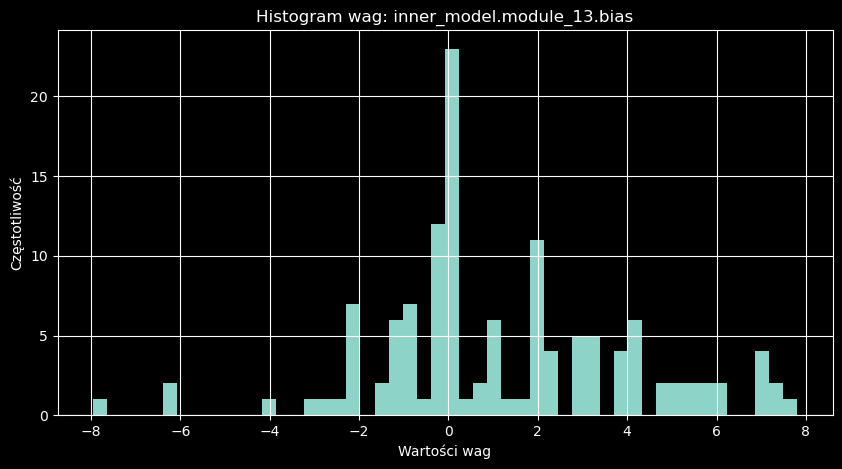

Wagi: inner_model.module_16.weight
Min: -0.25, Max: 0.21875
dtype: torch.float32
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0312, 0.0625])


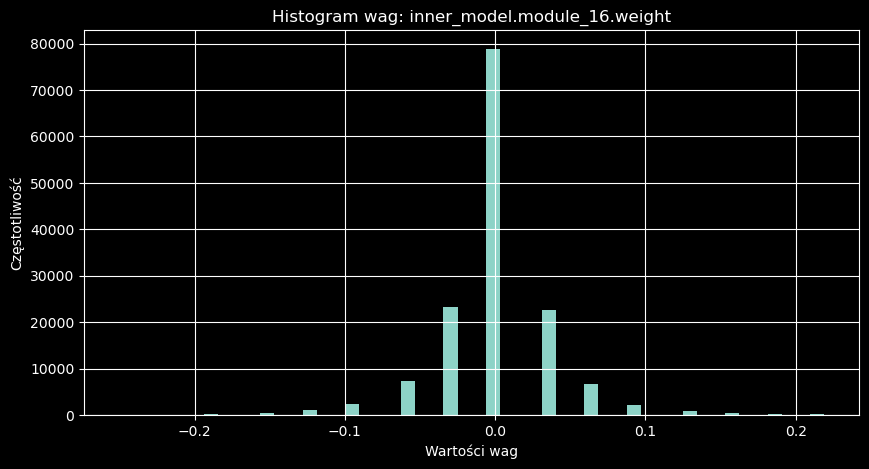

Wagi: inner_model.module_16.bias
Min: -9.696139335632324, Max: 13.520001411437988
dtype: torch.float32
tensor([ 8.5549, -0.0581,  6.1132,  4.7141, -1.7470,  5.4475,  8.8299, -4.0063,
         2.1296, 10.5352, -3.2427,  5.7266, -3.1936,  4.9438,  2.5254,  1.0902,
        -3.6423,  0.1383, -0.9153, -0.0168,  4.8084, -0.1445, -3.8182, -6.8460,
         1.0225, -0.5466, -1.0997, -5.9856,  4.1095, -2.1225, -0.1075, -0.0625,
         8.9546, -0.5026, -2.5427, -0.4079, -0.8867, -3.7927, -4.4368, -4.6426,
        -0.2137, -6.1772, -0.1554,  4.8371, -0.1120,  5.3556, -0.0215,  0.2781,
         5.6451, -3.3691, -2.6819,  0.4314,  3.5224, -0.1567,  0.0862, -3.1610,
         4.1299,  6.0399, -1.2494, -0.1087, -1.4730,  2.1250, -0.1024,  8.7784,
        -4.8001, -9.5842, -3.1339, -0.3918,  6.7790, -2.2891,  2.6605,  3.2412,
        -0.1729, -4.3171,  6.6643, -2.6814, -0.9956, 10.3255, -2.9431, -3.3739,
        10.2262, -1.9158, -0.3391,  0.1015,  3.7817, -1.7048, -1.2079, -0.1685,
        -0.5439, 

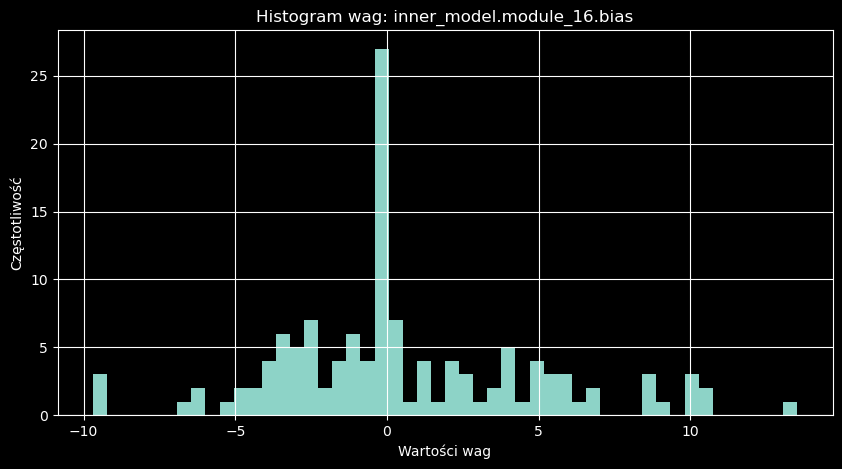

Wagi: inner_model.module_18.weight
Min: -0.25, Max: 0.21875
dtype: torch.float32
tensor([0., 0., 0.,  ..., 0., 0., 0.])


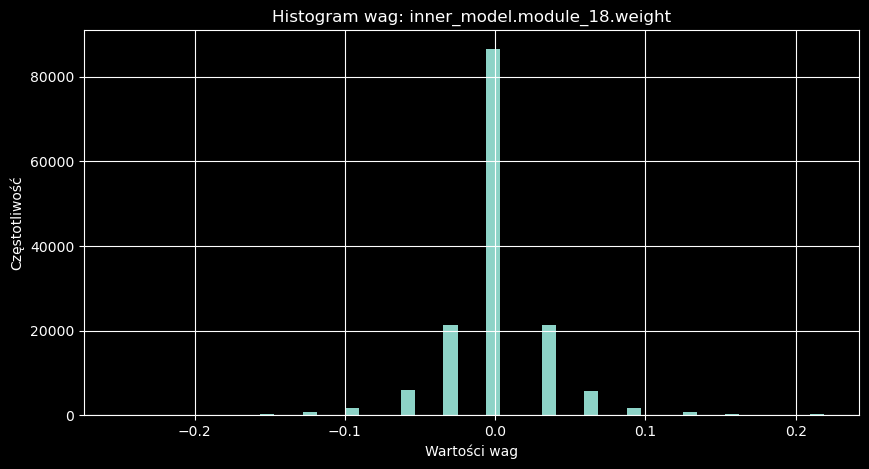

Wagi: inner_model.module_18.bias
Min: -9.138864517211914, Max: 15.518269538879395
dtype: torch.float32
tensor([-0.1243,  9.2925, -0.0295, 12.6651, -0.5876,  7.6320, -6.4412, -1.0908,
        -0.0449,  4.1440, -7.0411,  8.9914,  7.9962,  3.7742, -0.0916, -1.0244,
         4.6311, -0.0493,  6.9656, -1.0914, -4.5560, -2.5796, 13.4448, -5.4425,
         4.4347,  1.4231, -8.9615, -3.2973,  4.3861, -0.1008, -0.0735, -0.3897,
        -0.3616, -2.7506, -4.0523, -2.6846, -7.5365, -0.2156, -0.3555,  3.3993,
         1.0796, -2.2882,  2.5043, -0.3713, -1.3849, -2.5265, -1.9054, -0.5218,
         0.3483, -2.4315,  4.7673,  2.2480, -0.9138, -9.1389, -0.0793, -2.2102,
        -0.1597,  1.6093, -1.4305, -1.5496, -0.8197, -3.1088, -0.5728, -4.7983,
        -6.6589,  3.4983,  9.1528, -5.8000, -0.2107, -0.1499,  5.7241, -2.0891,
        -2.9389,  5.3166,  0.6601,  0.5167, -1.9847,  3.8355, -1.7313,  9.5076,
         2.5169, -3.3030, -0.0673,  2.9995, -2.4282, -0.3201, -4.6034,  0.0230,
        -2.9198, 

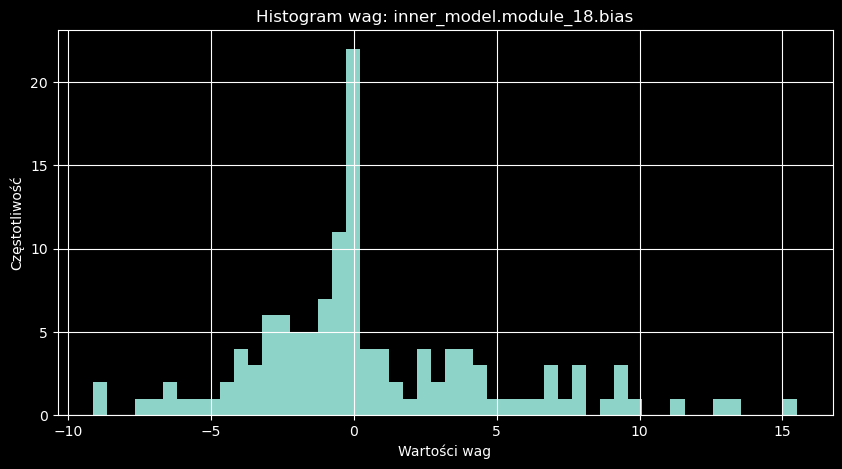

Wagi: inner_model.module_20.weight
Min: -0.25, Max: 0.21875
dtype: torch.float32
tensor([0., 0., 0.,  ..., 0., 0., 0.])


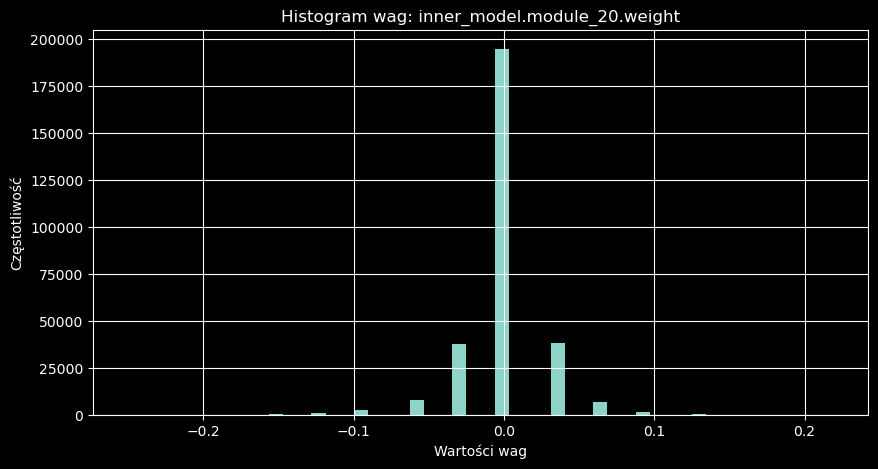

Wagi: inner_model.module_20.bias
Min: -14.512970924377441, Max: 18.50855827331543
dtype: torch.float32
tensor([ 2.8914e+00,  6.0458e+00, -2.2972e-01,  4.6968e+00, -1.5213e+00,
        -5.7775e+00, -1.8238e+00,  4.7991e+00,  5.5716e+00, -2.3273e+00,
         2.4526e+00, -3.9374e+00, -1.3786e+00,  3.0190e+00, -5.2100e+00,
         7.2133e-01, -2.7580e+00, -7.3826e-01, -1.6926e+00,  3.7817e+00,
         1.2901e+01, -2.3290e-01,  4.0698e+00,  1.8509e+01,  9.7035e-01,
        -5.3278e+00, -1.3656e+00,  4.6520e+00, -3.1409e+00, -3.1804e+00,
        -6.7005e+00,  2.1783e+00, -1.5716e+00, -1.1739e+01, -5.7656e+00,
         3.4862e-01,  6.5894e+00,  5.4292e+00, -3.7507e+00, -6.6391e+00,
        -1.5877e+00, -3.8818e+00,  4.2840e+00,  3.3185e+00, -1.9897e+00,
         7.4908e+00,  3.8230e+00, -1.5197e+00, -6.6088e-01, -5.7794e-01,
         2.3998e+00, -3.8018e+00, -3.3392e-01,  1.4303e+00, -4.5011e+00,
         2.0265e+00, -7.0889e+00, -1.9150e+00, -1.4706e+00,  1.4393e-01,
        -4.9572e+00, 

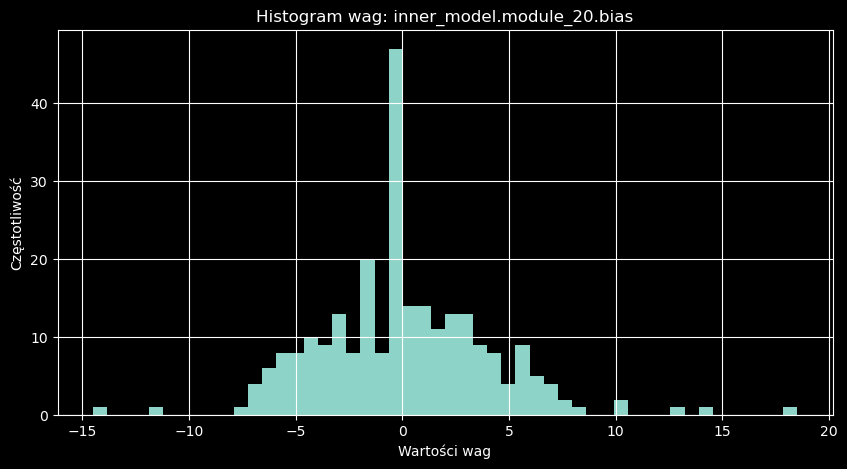

Wagi: inner_model.module_22.weight
Min: -0.5, Max: 0.4375
dtype: torch.float32
tensor([0.0625, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0625])


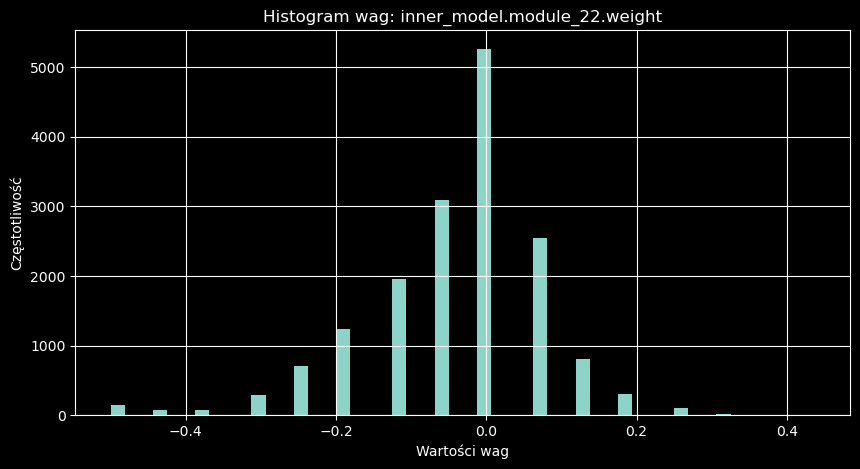

Wagi: inner_model.module_22.bias
Min: -1.7004159688949585, Max: 1.379907488822937
dtype: torch.float32
tensor([-1.3619, -1.0194, -0.9992, -1.2099, -1.3736, -1.1171, -1.5852, -1.6696,
        -0.9902, -0.8936, -0.9887, -0.7252, -0.8336, -0.7531, -0.9862, -1.7004,
        -1.4618, -1.1257, -0.6079, -0.4657, -0.4411, -0.8734, -0.6078, -0.9361,
        -1.1659, -1.4110, -0.9354, -1.1149, -0.4027, -0.2561, -0.8538, -0.7355,
        -1.6026, -0.9443, -0.7019, -1.0368, -0.6334, -0.7036, -1.1277, -1.2641,
        -1.1914, -0.9594, -0.6046, -0.5142, -0.7256, -0.2180, -0.6405, -1.6095,
        -0.8963, -0.5414, -0.8701, -0.4987, -0.1557,  0.1006, -0.1564, -1.0298,
        -1.2375, -1.1481, -1.0862, -0.8772, -1.1808, -0.7682, -1.2269, -1.5412,
         1.3799])


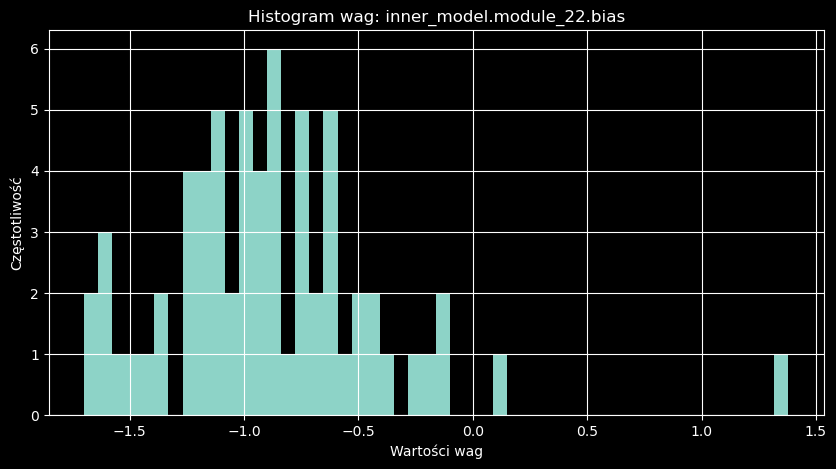

Wagi: inner_model.module_23.weight
Min: -1.0, Max: 0.875
dtype: torch.float32
tensor([0., 0., 0.,  ..., 0., 0., 0.])


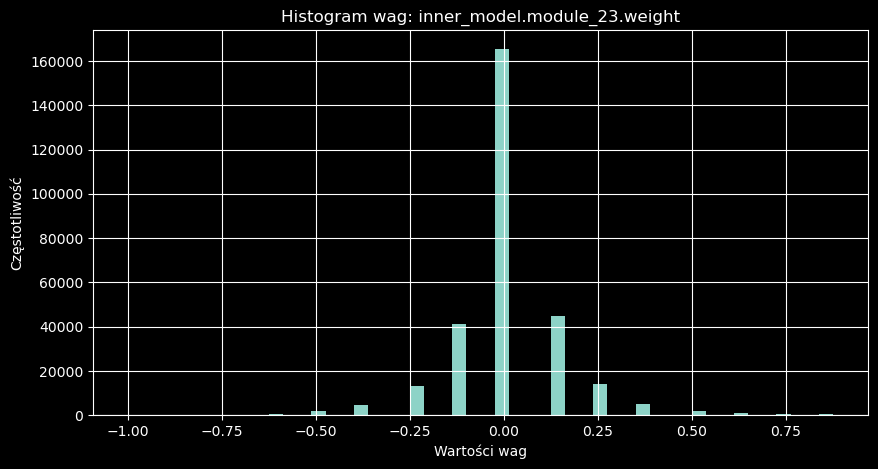

Wagi: inner_model.module_23.bias
Min: -50.68738555908203, Max: 21.944385528564453
dtype: torch.float32
tensor([-2.8622e+01, -3.1628e+01, -3.3751e+01, -1.2310e+01, -2.7311e+01,
        -3.2680e+01, -1.8165e+01, -1.5729e+01, -2.6392e+01, -2.4704e+01,
        -1.3307e+01, -1.7673e+01, -2.0616e+01, -1.8534e+01, -2.6253e+01,
        -2.9792e+01, -1.0809e+01, -2.4652e+01, -2.3034e+01, -2.1260e+01,
        -2.2803e+01, -2.3743e+01, -1.5723e+01, -3.4233e+01,  3.2286e+00,
        -3.0528e+01,  1.7557e+00, -9.4543e-02, -2.8312e+01, -2.2615e+01,
        -9.3236e-02, -2.3896e+01, -7.8819e-02, -6.4701e+00, -2.5214e+01,
         2.3207e+00, -8.5981e+00, -1.9123e+01, -8.1361e-02,  1.9974e+01,
        -3.8515e+01, -1.2285e-01, -2.7117e+01, -1.2388e-01, -2.0608e+01,
        -2.8969e+01, -2.5954e+01, -3.1754e+01, -7.8531e+00, -1.5632e+01,
        -4.9206e-02, -9.5565e-02, -3.6451e+01, -3.2274e+01, -7.0622e-02,
        -2.0283e+00, -2.3188e+01, -2.1375e+01, -5.2787e+00, -4.0906e+01,
        -3.4230e+01, 

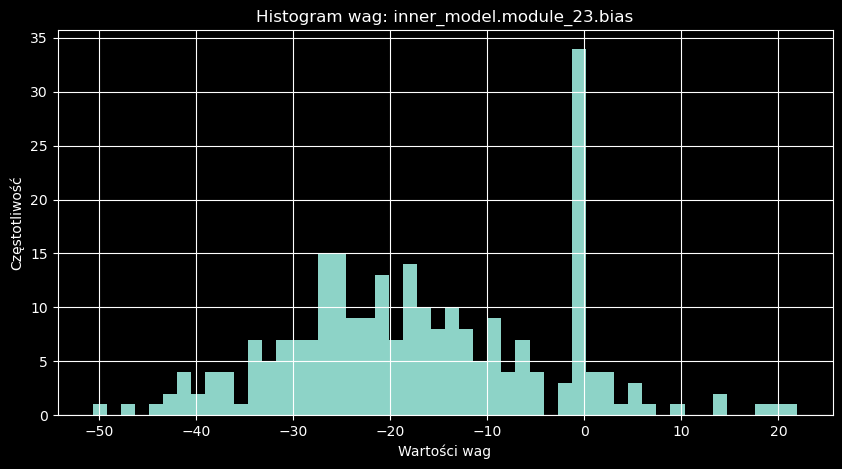

Wagi: inner_model.module_25.weight
Min: -1.0, Max: 0.875
dtype: torch.float32
tensor([ 0.6250,  0.0000,  0.3750,  ...,  0.3750,  0.5000, -0.6250])


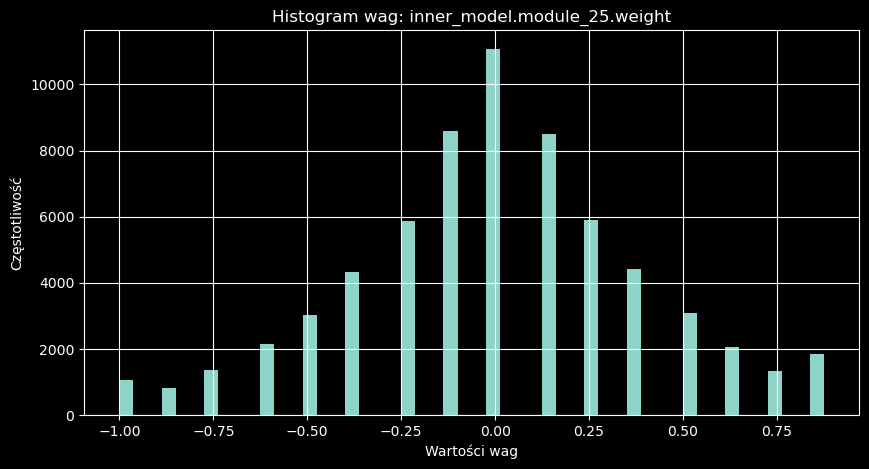

Wagi: inner_model.module_25.bias
Min: -6.911043643951416, Max: 10.725379943847656
dtype: torch.float32
tensor([ 7.6115e-02, -1.5477e+00,  1.7246e+00, -3.3499e+00, -1.4316e+00,
         7.4887e-02, -1.9137e+00, -1.4813e+00, -6.1209e+00, -4.4842e+00,
         5.0705e+00,  5.1339e-01,  2.8901e+00,  9.4668e-01,  2.8083e+00,
        -1.4382e-01,  2.9354e-01, -1.4050e+00,  5.8020e+00,  2.8225e+00,
         4.5021e-01,  4.8888e+00, -9.8037e-01, -3.0416e+00, -3.7573e+00,
         1.0536e+00,  8.7101e-01,  3.0519e+00, -6.5394e-02, -2.0347e+00,
         3.6529e+00,  3.8043e+00, -5.4145e-01, -3.8443e+00, -4.9662e-01,
         1.5257e+00, -9.9051e-01,  1.3453e+00,  7.5281e-04,  9.7798e+00,
         3.6012e-01, -6.4266e-01, -1.2618e-01,  3.2994e+00,  2.1434e+00,
        -4.2246e+00,  7.6847e+00,  6.7864e+00,  1.8972e+00,  2.2678e-01,
        -1.4364e+00,  2.1136e+00,  2.7405e+00,  2.4588e+00,  4.5642e+00,
         9.0002e-01, -2.9582e+00, -4.5502e+00,  2.3277e+00, -1.8883e+00,
        -5.5627e-01, 

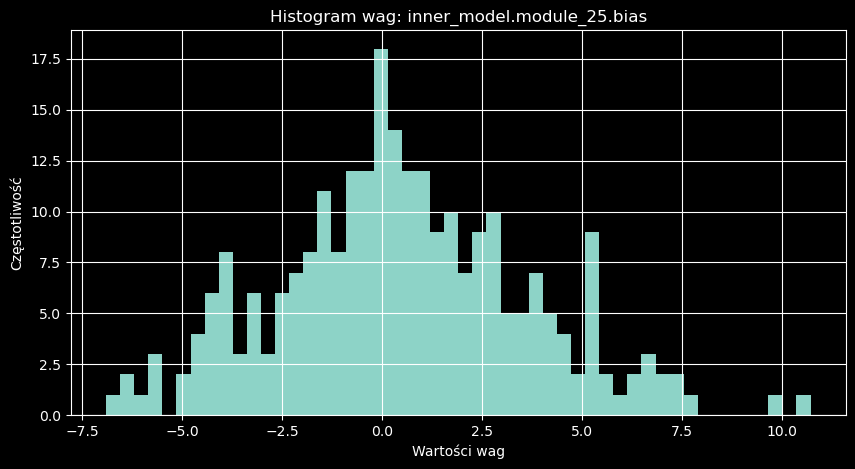

In [73]:
# display weights
def display_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            values = param.detach().cpu().view(-1)
            print(f"Wagi: {name}")
            print(f"Min: {values.min().item()}, Max: {values.max().item()}")
            print(f"dtype: {values.dtype}")
            print(values)
            plt.figure(figsize=(10, 5))
            plt.hist(values.numpy(), bins=50)
            plt.title(f"Histogram wag: {name}")
            plt.xlabel("Wartości wag")
            plt.ylabel("Częstotliwość")
            plt.grid()
            plt.show()
display_weights(quantized_model)

In [68]:
# compile model
# /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json
# !vai_c_xir --help
!vai_c_xir --xmodel 'quant_dir/SuperPointNet_int.xmodel' --arch /workspace/SuperPoint/kria_evaluation/arch.json --net_name SuperPoint_wasala_isa0_int8 --output_dir build 

53609.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: SuperPointNet, with op num: 90
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/SuperPoint/kria_evaluation/build/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/SuperPoint/kria_evaluation/build/SuperPoint_wasala_isa0_int8.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is 96be1fffdce2d45aebcca91fdc100535, and has been saved to "/workspace/SuperPoint/kria_evaluation/build/md5sum.txt"


Teraz przejdziemy do testowania modelu na sprzęcie docelowym.

#### Wersja 1: Podłączenie do sieci
Zanim podłączysz zasilanie do Kria, podepnij kabel USB do komputera, a kabel Ethernetowy do sieci, w której znajduje się komputer.

Podłącz Kria do zasilania i poczekaj minutę, aż system się uruchomi.

Uruchom `cutecom` z `sudo`. Włącz port odpowiadający do Kria. Jeżeli pojawi się napis `kria login:` zaloguj się:

`login: ubuntu`

`hasło: Xilinx123`

Po zalogowaniu się, powinny pojawić się informacje systemowe. Nas interesuje adres `IPv4` dla `eth0`. Skopiuj go i dodaj do niego `:9090` - przykładowa wartość `192.168.1.26:9090`. Wklej to w przeglądarce. Powinien pojawić się kolejny Jupyter. Zaloguj się do niego hasłem:

`xilinx`

#### Wersja 2: Podłączenie do komputera
Zanim podłączysz zasilanie do Kria, podepnij kabel USB do komputera oraz kabel Ethernetowy pomiędzy Kria a PC. Na PC włącz ustawienia sieci `Wired Setting` -> `IPv4` -> `Shared to other computers`. Włącz zasilanie płytki.
Uruchom `cutecom` z `sudo`. Włącz port odpowiadający do Kria. Jeżeli pojawi się napis `kria login:` zaloguj się:

`login: ubuntu`

`hasło: Xilinx123`

Po zalogowaniu się, powinny pojawić się informacje systemowe. Nas interesuje adres `inet` dla `eth0`. Skopiuj go i dodaj do niego `:9090` - przykładowa wartość `10.42.0.47:9090`. Wklej to w przeglądarce. Powinien pojawić się kolejny Jupyter. Zaloguj się do niego hasłem:

`xilinx`

#### Przesyłanie plików
Stwórz nowy folder i nazwij go `PSRA_Lab`. Przenieś do niego odpowiednio pliki:
- dpu.bit, 
- dpu.hwh, 
- dpu.xclbin, 
- eval_MNIST.npz lub tak jak nazwałeś swój plik z danymi do ewaluacji
- MiniResNet_compiled.xmodel lub tak jak nazwałeś swój skompilowany plik

Można to wykonać komendą `scp`, ale łatwiej jest przeciągnąć pliki z folderu do Jupyter Notebook'a.

# UWAGA! 

Jeżeli wystąpi problem z adresami IPv4 Kria (po podłaczeniu kilku płytek do jednej sieci, każda z nich będzie miała taki sam adres), należy sprawdzić, czy działa komenda w konsoli `cutecom`:

`ifconfig`

Jeżeli nie, to należy zainstalować poprzez:

 `sudo apt install net-tools`.  
 
Po tym należy odpiąć kabel Ethernet z Kria, poczekać kilka sekund i wpisać w konsole `cutecom`:

`hostname -I`

Jeżeli konsola nie zwróci żadnego błędu oraz żadnego aresu IP to wpisz w konsole `cutecom`:

`sudo ifconfig eth0 192.168.1.x netmask 255.255.255.0`

Tutaj podany adres powinien być taki sam jak przykładowa wartość wyżej. Ustawiamy wartość `x` na inną niż była np. 123. Chcemy uniknąć konfliktu pomiędzy płytkami ale również komputerami. Po tym znowu ponawiamy:

`hostname -I`.

Powinien pojawić sie ustawiony przez nas adres. Podpinamy kabel Ethernet i uruchamiamy w przeglądarce Jupyter z ustawionym adresem IP.